# Часть 2 - Моделирование с помощью xgbse


## Исморт данных и основных пакетов

In [25]:
pip install xgbse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from xgboost import XGBClassifier
from xgbse import XGBSEKaplanNeighbors
from xgbse.converters import convert_y, convert_to_structured
from xgbse.non_parametric import get_time_bins
from xgbse.metrics import concordance_index

from xgbse import (
    XGBSEKaplanNeighbors,
    XGBSEKaplanTree,
    XGBSEDebiasedBCE,
    XGBSEBootstrapEstimator
)

pd.set_option('display.float', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

import time
import warnings
warnings.filterwarnings('ignore')
plt.style.use('bmh')

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
data = pd.read_csv("drive/MyDrive/Course Work/lending_club_dataset_for_xgbse.csv", low_memory = False)
data.drop('Unnamed: 0', axis = 1, inplace = True)
print('Исходный датасет, подготовленный в части №1:')
print(data.shape)
data.head()

Исходный датасет, подготовленный в части №1:
(1188252, 47)


,loan_amnt,grade,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_util,initial_list_status,recoveries,application_type,tot_coll_amt,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,mo_sin_old_il_acct,mort_acc,num_il_tl,num_rev_tl_bal_gt_0,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,disbursement_method,debt_settlement_flag,loan_result,lines_acc_diff,num_rev_acc_diff,mo_tl_op_diff,mths_since_recent_diff,num_sats_diff,fico_range_avg,duration,home_ownership_OWN,home_ownership_RENT,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_other,addr_state_NorthEast,addr_state_SouthEast,addr_state_SouthWest,addr_state_West
0,3600.000,5,55000.000,0,5.910,0.000,1.000,0.000,29.700,1,0.000,1,722.000,9300.000,4.000,20701.000,148.000,1.000,3.000,4.000,0.000,76.900,0.000,0.000,178050.000,7746.000,2400.000,1,1,1,6.000,5.000,125.000,0.000,5.000,677.000,36.000,0,0,1,0,0,0,1,0,0,0
1,20000.000,6,63000.000,0,10.780,0.000,0.000,0.000,56.200,1,0.000,0,0.000,14000.000,6.000,31617.000,125.000,5.000,6.000,3.000,0.000,100.000,50.000,0.000,218418.000,18696.000,6200.000,1,1,1,12.000,3.000,170.000,91.000,4.000,697.000,60.000,0,0,0,1,0,0,0,0,0,0
2,10400.000,2,104433.000,2,25.370,1.000,3.000,0.000,64.500,1,0.000,1,0.000,34000.000,10.000,27644.000,128.000,6.000,10.000,6.000,0.000,96.600,60.000,0.000,439570.000,95768.000,20300.000,1,1,1,23.000,12.000,206.000,3.000,7.000,697.000,60.000,0,0,0,0,1,0,1,0,0,0
3,11950.000,5,34000.000,2,10.200,0.000,0.000,0.000,68.400,1,0.000,1,0.000,12900.000,0.000,2560.000,338.000,0.000,2.000,3.000,0.000,100.000,100.000,0.000,16900.000,12798.000,9400.000,1,1,1,1.000,0.000,22.000,15.559,3.000,692.000,36.000,0,1,1,0,0,0,0,1,0,0
4,20000.000,6,180000.000,0,14.670,0.000,0.000,0.000,84.500,0,0.000,1,0.000,94200.000,6.000,30030.000,142.000,4.000,7.000,6.000,0.000,96.300,100.000,0.000,388852.000,116762.000,31500.000,1,1,1,15.000,7.000,296.000,2.000,8.000,682.000,36.000,0,0,1,0,0,0,0,0,0,0


In [30]:
print('Так как при использовании xgbse мы моделируем вероятность выхода в дефолт (вероятность выживания), результат кредита должен быть обратным')
print('То есть сейчас loan_result = 1 означает, что кредит был выплачен, в то время как при моделировании единицей необходимо обозначать то, что клиент вышел в дефолт')
print('Перекодируем фичу loan_result, поменяв местами 1 и 0')

print('Распределение результатов кредита до изменений:')
print(data.loan_result.value_counts())

data['loan_result'] = data['loan_result'].map({1: 0, 0: 1})

print('Распределение результатов кредита после изменений:')
print(data.loan_result.value_counts())

Так как при использовании xgbse мы моделируем вероятность выхода в дефолт (вероятность выживания), результат кредита должен быть обратным
То есть сейчас loan_result = 1 означает, что кредит был выплачен, в то время как при моделировании единицей необходимо обозначать то, что клиент вышел в дефолт
Перекодируем фичу loan_result, поменяв местами 1 и 0
Распределение результатов кредита до изменений:
1    958655
0    229597
Name: loan_result, dtype: int64
Распределение результатов кредита после изменений:
0    958655
1    229597
Name: loan_result, dtype: int64


## Основная часть моделирования

##### Temporary initialize

In [7]:
tt500 = pd.read_csv("/content/drive/MyDrive/Course Work/train-test-500.csv", low_memory = False)
print('500_000 строк для поиска гиперпараметров:')
print(tt500.shape)
tt500.head()

500_000 строк для поиска гиперпараметров:
(500000, 48)


,Unnamed: 0,loan_amnt,grade,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_util,initial_list_status,recoveries,application_type,tot_coll_amt,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,mo_sin_old_il_acct,mort_acc,num_il_tl,num_rev_tl_bal_gt_0,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,disbursement_method,debt_settlement_flag,loan_result,lines_acc_diff,num_rev_acc_diff,mo_tl_op_diff,mths_since_recent_diff,num_sats_diff,fico_range_avg,duration,home_ownership_OWN,home_ownership_RENT,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_other,addr_state_NorthEast,addr_state_SouthEast,addr_state_SouthWest,addr_state_West
0,614387,25000.000,6,50000.000,2,23.820,0.000,0.000,0.000,51.000,1,0.000,1,0.000,64100.000,1.000,4084.000,191.000,2.000,3.000,7.000,0.000,100.000,50.000,0.000,64100.000,32674.000,49400.000,1,1,0,11.000,6.000,328.000,-4.000,2.000,717.000,60.000,0,0,0,0,0,0,0,1,0,0
1,957420,5000.000,6,130000.000,2,21.410,1.000,0.000,0.000,66.500,1,0.000,1,0.000,129321.000,3.000,17066.000,147.000,7.000,17.000,11.000,0.000,98.000,80.000,0.000,515409.000,181596.000,26300.000,1,1,0,27.000,13.000,179.000,36.000,20.000,692.000,36.000,0,0,0,0,0,0,0,0,0,0
2,54111,15000.000,7,47000.000,0,18.620,0.000,0.000,0.000,21.400,1,0.000,1,0.000,21700.000,3.000,32042.000,120.000,7.000,3.000,5.000,0.000,100.000,33.300,0.000,251161.000,34845.000,12200.000,1,1,0,11.000,3.000,103.000,41.000,4.000,767.000,36.000,0,0,1,0,0,0,0,0,0,0
3,416705,8000.000,7,49000.000,0,20.160,0.000,0.000,0.000,14.400,1,0.000,1,0.000,67100.000,5.000,19831.000,154.000,3.000,22.000,6.000,0.000,96.400,0.000,0.000,294865.000,64991.000,63500.000,1,1,0,46.000,25.000,249.000,-18.000,6.000,717.000,36.000,0,0,1,0,0,0,0,1,0,0
4,888818,12200.000,5,98000.000,1,16.260,0.000,0.000,1.000,78.300,0,0.000,1,0.000,4200.000,6.000,11489.000,125.000,1.000,16.000,2.000,0.000,96.200,50.000,1.000,72173.000,57444.000,4200.000,1,1,0,24.000,9.000,156.000,15.559,3.000,662.000,36.000,0,1,1,0,0,0,0,0,0,1


In [8]:
df = data[data.index.isin(tt500['Unnamed: 0'])]
df.head()

,loan_amnt,grade,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_util,initial_list_status,recoveries,application_type,tot_coll_amt,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,mo_sin_old_il_acct,mort_acc,num_il_tl,num_rev_tl_bal_gt_0,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,disbursement_method,debt_settlement_flag,loan_result,lines_acc_diff,num_rev_acc_diff,mo_tl_op_diff,mths_since_recent_diff,num_sats_diff,fico_range_avg,duration,home_ownership_OWN,home_ownership_RENT,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_other,addr_state_NorthEast,addr_state_SouthEast,addr_state_SouthWest,addr_state_West
3,11950.000,5,34000.000,2,10.200,0.000,0.000,0.000,68.400,1,0.000,1,0.000,12900.000,0.000,2560.000,338.000,0.000,2.000,3.000,0.000,100.000,100.000,0.000,16900.000,12798.000,9400.000,1,1,0,1.000,0.000,22.000,15.559,3.000,692.000,36.000,0,1,1,0,0,0,0,1,0,0
5,20000.000,6,85000.000,0,17.610,1.000,0.000,0.000,5.700,1,0.000,1,0.000,14500.000,4.000,17700.000,149.000,3.000,9.000,2.000,1.000,93.300,0.000,0.000,193390.000,27937.000,14500.000,1,1,0,7.000,0.000,23.000,24.000,5.000,707.000,36.000,0,0,0,0,1,0,0,1,0,0
9,18000.000,3,150000.000,0,9.390,0.000,1.000,1.000,40.700,1,1618.900,1,60.000,34500.000,7.000,2014.000,115.000,2.000,6.000,13.000,0.000,100.000,14.300,1.000,65819.000,36247.000,10300.000,1,1,1,9.000,3.000,111.000,7.000,11.000,667.000,16.000,0,1,1,0,0,0,0,0,0,1
11,9600.000,7,60000.000,0,22.440,0.000,0.000,0.000,59.400,1,0.000,1,0.000,13000.000,2.000,7912.000,234.000,0.000,5.000,3.000,0.000,100.000,66.700,0.000,88635.000,55387.000,12500.000,1,1,0,2.000,0.000,82.000,2.000,4.000,697.000,36.000,0,0,0,0,0,0,0,1,0,0
12,25000.000,7,109000.000,0,26.020,0.000,1.000,0.000,54.300,1,0.000,1,0.000,38400.000,2.000,33976.000,142.000,3.000,7.000,3.000,0.000,100.000,20.000,0.000,373572.000,68056.000,38400.000,1,1,0,10.000,4.000,155.000,13.000,4.000,747.000,36.000,0,0,1,0,0,0,0,1,0,0


### Вспомогательные методы и параметры по-умолчанию


In [31]:
PARAMS_XGB_AFT = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'gpu_hist', 
    'learning_rate': 5e-2, 
    'max_depth': 3, 
    'booster': 'gbtree',
    'subsample': 0.5,
    'min_child_weight': 50,
    'colsample_bynode': 0.5
}

PARAMS_LR = {
    'C': 1e-3,
    'max_iter': 500
}

N_ESTIMATORS = 20

TIME_BINS = np.arange(1, 61, 1)

In [32]:
def plot_ci(mean, upper_ci, lower_ci, i = 0, title = f'Вероятность выхода в дефолт', figsize = (12, 8)):
    plt.figure(figsize = figsize)
    plt.plot(mean.columns, mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha = 0.2)

    plt.title(title)
    plt.xlabel('Месяц')
    plt.ylabel(f'Вероятность дефолта клиента №{i}')
    plt.tight_layout()

In [33]:
def plot_all_cis(mean, title = 'Вероятность выхода в дефолт всех клиентов', figsize = (12, 8)):
    plt.figure(figsize = figsize)
    plt.plot(mean.T, color = '#2190de', alpha = 0.9)

    plt.title(title)
    plt.xlabel('Месяц')
    plt.ylabel('Вероятность дефолта')
    plt.tight_layout()

In [34]:
def plot_dis(df):
  sns.displot(data = df, x = 'duration', hue = 'loan_result', multiple = "stack", legend = False)
  plt.legend(['Просрочен', 'Выплачен'])
  plt.title('Распределение duration в разрезе статуса')
  plt.xlabel('Значение duration (в месяцах)')
  plt.ylabel('Число строк')
  plt.tight_layout()

### Краткий обзор возможностей xgbse


In [35]:
print('Проведем небольшой обзор основных функций и моделей пакета xgbse')
print('Для этого возьмем небольшую выборку данных - 10.000 записей датасета и будем использовать ее\n')

df = data.sample(n = 10_000)
display(df.head())

Проведем небольшой обзор основных функций и моделей пакета xgbse
Для этого возьмем небольшую выборку данных - 10.000 записей датасета и будем использовать ее


,loan_amnt,grade,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_util,initial_list_status,recoveries,application_type,tot_coll_amt,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,mo_sin_old_il_acct,mort_acc,num_il_tl,num_rev_tl_bal_gt_0,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,disbursement_method,debt_settlement_flag,loan_result,lines_acc_diff,num_rev_acc_diff,mo_tl_op_diff,mths_since_recent_diff,num_sats_diff,fico_range_avg,duration,home_ownership_OWN,home_ownership_RENT,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_other,addr_state_NorthEast,addr_state_SouthEast,addr_state_SouthWest,addr_state_West
250841,10000.000,6,60000.000,0,18.920,4.000,2.000,0.000,35.000,1,0.000,1,10375.000,41100.000,4.000,951.000,136.000,0.000,2.000,6.000,4.000,93.000,0.000,0.000,41100.000,14265.000,38000.000,1,1,0,11.000,12.000,170.000,12.000,5.000,672.000,36.000,0,0,0,0,0,0,0,0,0,1
950252,8775.000,6,38000.000,2,28.420,1.000,1.000,1.000,87.100,0,0.000,1,0.000,8000.000,2.000,7079.000,124.000,2.000,24.000,4.000,0.000,97.000,100.000,1.000,155132.000,57531.000,6500.000,1,1,0,12.000,2.000,148.000,48.000,18.000,697.000,36.000,0,0,0,1,0,0,0,0,1,0
42715,7000.000,5,47652.000,2,3.600,0.000,0.000,0.000,94.600,1,0.000,1,0.000,4800.000,2.000,36049.000,126.000,2.000,6.000,3.000,0.000,100.000,100.000,0.000,147300.000,4540.000,4800.000,1,1,0,7.000,0.000,1.000,46.000,1.000,677.000,36.000,0,0,1,0,0,0,0,0,0,1
873783,6725.000,6,85000.000,2,17.200,0.000,1.000,2.000,37.500,1,0.000,1,318.000,15700.000,8.000,2599.000,140.000,0.000,14.000,6.000,0.000,76.000,50.000,0.000,97314.000,31190.000,8400.000,1,1,0,13.000,1.000,134.000,4.000,8.000,712.000,36.000,0,1,1,0,0,0,0,0,0,0
467824,7200.000,5,50000.000,1,26.190,0.000,1.000,6.000,32.500,0,0.000,1,1264.000,11800.000,5.000,12140.000,128.000,1.000,14.000,3.000,0.000,95.800,0.000,0.000,167036.000,32539.000,3300.000,1,1,1,13.000,3.000,61.000,13.000,9.000,717.000,8.000,0,0,1,0,0,0,0,1,0,0


Посмотрим на распределение таргетных переменных для моделирования - duration и loan_result:



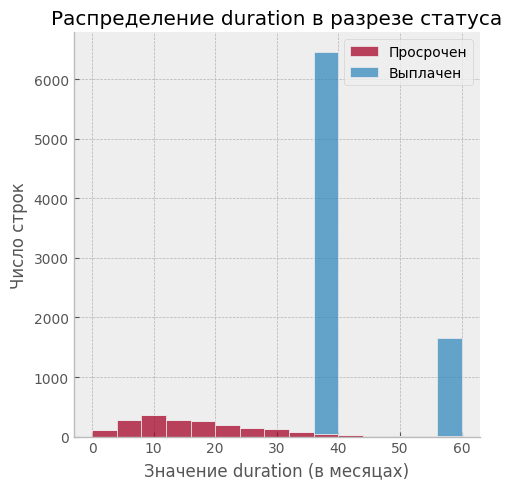

In [36]:
print('Посмотрим на распределение таргетных переменных для моделирования - duration и loan_result:\n')
plot_dis(df)

In [37]:
print('Определим переменные X и Y и разделим из на train и test части')
print('Для XGBSEDebiasedBCE переменная X будет содержать все столбцы датасета кроме duration и loan_result')
print('Таргетные переменные duration и loan_result конвертируются в собственную структуру и являются переменной Y')
print('Для обзора возможностей xgbse разделим части на train и test как 1 : 4')

X = df.drop(['duration', 'loan_result'], axis = 1)
y = convert_to_structured(df['duration'], df['loan_result'])

(X_train, X_valid, y_train, y_valid) = train_test_split(X, y, test_size = 0.2, random_state = 42)

Определим переменные X и Y и разделим из на train и test части
Для XGBSEDebiasedBCE переменная X будет содержать все столбцы датасета кроме duration и loan_result
Таргетные переменные duration и loan_result конвертируются в собственную структуру и являются переменной Y
Для обзора возможностей xgbse разделим части на train и test как 1 : 4


In [38]:
print('Обучим модель XGBSEDebiasedBCE для нахождения вероятности выживания каждого клиента')
print('Под выживанием в данном случае понимается вероятность того, что клиент сможет выплатить кредит')
print('Результат модели будем оценивать по показателю C-index (concordance index)')

base_model = XGBSEDebiasedBCE(PARAMS_XGB_AFT, PARAMS_LR)
bootstrap_estimator = XGBSEBootstrapEstimator(base_model, n_estimators = N_ESTIMATORS)

bootstrap_estimator.fit(
    X_train,
    y_train,
    validation_data = (X_valid, y_valid),
    early_stopping_rounds = 10,
    time_bins = TIME_BINS,
)

mean_DBCE, upper_ci_DBCE, lower_ci_DBCE = bootstrap_estimator.predict(X_valid, return_ci = True)
cind_DBCE = concordance_index(y_valid, mean_DBCE)
print(f"Показатель C-index модели (индекс согласия): {cind_DBCE:.3f}")

Обучим модель XGBSEDebiasedBCE для нахождения вероятности выживания каждого клиента
Под выживанием в данном случае понимается вероятность того, что клиент сможет выплатить кредит
Результат модели будем оценивать по показателю C-index (concordance index)
Показатель C-index модели (индекс согласия): 0.862


In [40]:
print('Также обучим модель XGBSEKaplanNeighbors')

xgbse_model = XGBSEKaplanNeighbors(n_neighbors = 20)
xgbse_model.fit(X_train, y_train, time_bins = TIME_BINS)

mean_KN, upper_ci_KN, lower_ci_KN = xgbse_model.predict(X_valid, return_ci = True)
cind_KN = concordance_index(y_valid, mean_KN)
print(f"Показатель C-index модели (индекс согласия): {cind_KN:.3f}")

Также обучим модель XGBSEKaplanNeighbors
Показатель C-index модели (индекс согласия): 0.833


In [41]:
print('Итого, для случайных 10.000 строк датасета результирующая оценка C-index у моделей следующая:')
print(f'XGBSEDebiasedBCE {cind_DBCE:.3f}')
print(f'XGBSEKaplanNeighbors {cind_KN:.3f}')

Итого, для случайных 10.000 строк датасета результирующая оценка C-index у моделей следующая:
XGBSEDebiasedBCE 0.862
XGBSEKaplanNeighbors 0.833


In [42]:
from lifelines import KaplanMeierFitter

print('Также построим кривую Каплана-Мейера с помощью пакета lifilines и сравним средние кривые моделей с ней')
kmf = KaplanMeierFitter()
kmf.fit(df['duration'], event_observed = df['loan_result'])

Также построим кривую Каплана-Мейера с помощью пакета lifilines и сравним средние кривые моделей с ней


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 10000 total observations, 8080 right-censored observations>

Сравним средние кривые выживания, предсказанные разными моделями и реальную кривую выживаемости Каплана-Мейера:

Чем ближе будет кривая, построенная моделью к кривой Каплана-Мейера, тем точнее модель будет предсказывать данные


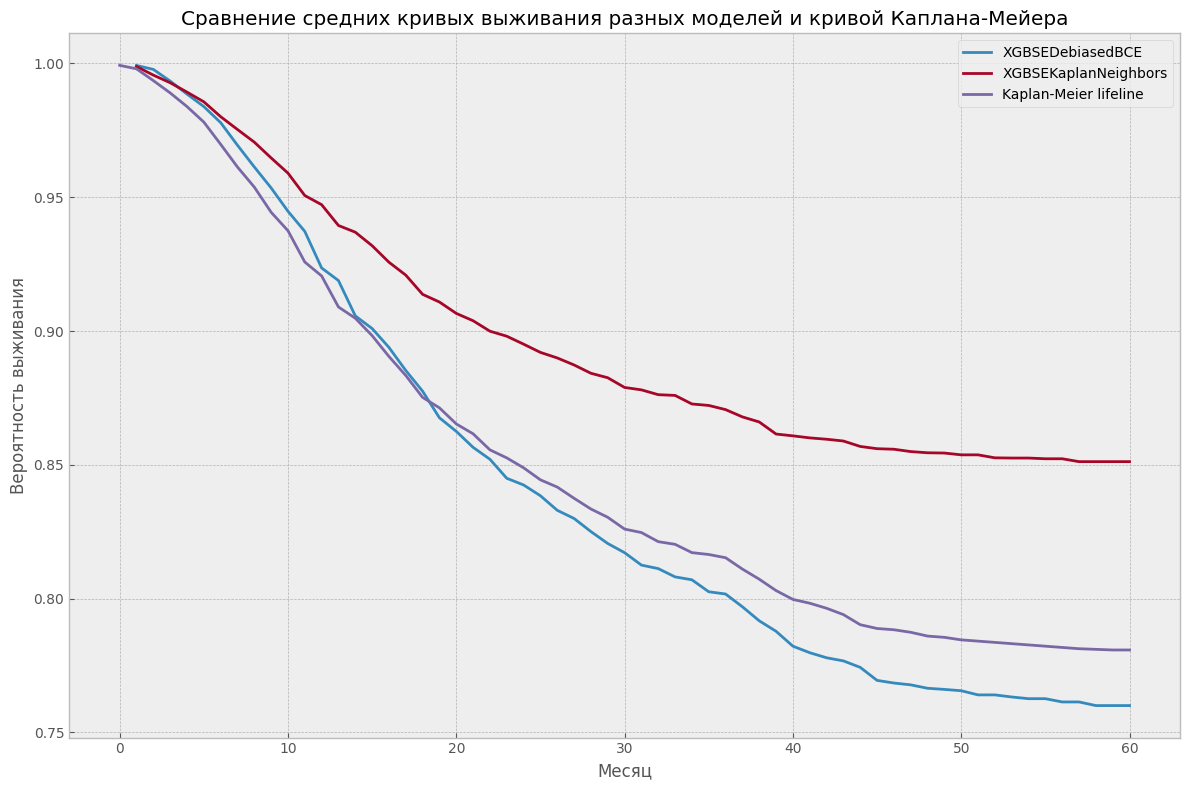

In [43]:
print('Сравним средние кривые выживания, предсказанные разными моделями и реальную кривую выживаемости Каплана-Мейера:\n')
print('Чем ближе будет кривая, построенная моделью к кривой Каплана-Мейера, тем точнее модель будет предсказывать данные')

plt.figure(figsize = (12, 8))
plt.plot(mean_DBCE.mean())
plt.plot(mean_KN.mean())
plt.plot(kmf.survival_function_)
plt.legend(['XGBSEDebiasedBCE', 'XGBSEKaplanNeighbors', 'Kaplan-Meier lifeline'])

plt.title('Сравнение средних кривых выживания разных моделей и кривой Каплана-Мейера')
plt.xlabel('Месяц')
plt.ylabel(f'Вероятность выживания')
plt.tight_layout()

In [44]:
print('Видно, что модель XGBSEDebiasedBCE даже на 10.000 случайных данных очень близка к реальной кривой Каплана-Мейера')
print('Для моделирования результирующей кривой выживаемости будем использовать именно ее')

mean = mean_DBCE
rev_mean = 1 - mean_DBCE
rev_upper_ci = 1 - upper_ci_DBCE
rev_lower_ci = 1 - lower_ci_DBCE

print('В результате работы модели получается таблица с вероятностями выживания каждого клиента за каждый месяц:\n')
display(mean.head())
print('Для того, чтобы получить вероятности выхода в дефолт за каждый месяц, значения таблицы можно вычесть из единицы:\n')
display(rev_mean.head())

Видно, что модель XGBSEDebiasedBCE даже на 10.000 случайных данных очень близка к реальной кривой Каплана-Мейера
Для моделирования результирующей кривой выживаемости будем использовать именно ее
В результате работы модели получается таблица с вероятностями выживания каждого клиента за каждый месяц:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.999,0.998,0.994,0.990,0.986,0.981,0.974,0.969,0.962,0.956,0.951,0.943,0.939,0.931,0.927,0.922,0.916,0.909,0.902,0.898,0.893,0.889,0.884,0.881,0.878,0.873,0.870,0.866,0.862,0.859,0.855,0.854,0.851,0.850,0.846,0.845,0.840,0.834,0.830,0.824,0.822,0.820,0.819,0.816,0.811,0.810,0.809,0.808,0.808,0.807,0.805,0.805,0.805,0.804,0.804,0.803,0.803,0.801,0.801,0.801
1,0.999,0.998,0.995,0.992,0.988,0.985,0.980,0.976,0.971,0.967,0.962,0.956,0.953,0.947,0.944,0.939,0.935,0.930,0.924,0.921,0.917,0.914,0.909,0.907,0.904,0.900,0.898,0.894,0.891,0.888,0.884,0.883,0.881,0.879,0.876,0.875,0.870,0.865,0.861,0.855,0.853,0.851,0.849,0.847,0.842,0.841,0.840,0.838,0.838,0.837,0.836,0.836,0.835,0.834,0.834,0.833,0.833,0.832,0.832,0.832
2,0.999,0.998,0.993,0.988,0.983,0.977,0.968,0.961,0.954,0.946,0.940,0.927,0.923,0.913,0.908,0.901,0.893,0.886,0.877,0.872,0.866,0.861,0.855,0.852,0.848,0.843,0.839,0.835,0.830,0.826,0.821,0.820,0.816,0.815,0.811,0.810,0.805,0.800,0.796,0.790,0.787,0.785,0.784,0.781,0.777,0.776,0.775,0.774,0.773,0.773,0.771,0.771,0.770,0.770,0.770,0.768,0.768,0.767,0.767,0.767
3,0.999,0.998,0.994,0.989,0.985,0.980,0.973,0.967,0.961,0.954,0.948,0.938,0.934,0.926,0.922,0.916,0.909,0.903,0.895,0.891,0.886,0.882,0.876,0.874,0.870,0.865,0.862,0.858,0.854,0.851,0.846,0.844,0.841,0.840,0.836,0.835,0.830,0.824,0.820,0.814,0.812,0.810,0.809,0.806,0.801,0.800,0.799,0.798,0.797,0.797,0.795,0.795,0.794,0.794,0.794,0.792,0.792,0.791,0.791,0.791
4,0.999,0.998,0.993,0.988,0.983,0.978,0.968,0.962,0.955,0.948,0.941,0.929,0.925,0.915,0.910,0.903,0.895,0.887,0.878,0.873,0.867,0.862,0.855,0.853,0.849,0.844,0.840,0.836,0.831,0.828,0.823,0.821,0.818,0.817,0.813,0.812,0.807,0.802,0.798,0.792,0.790,0.788,0.786,0.784,0.779,0.778,0.777,0.776,0.776,0.775,0.774,0.774,0.773,0.772,0.772,0.771,0.771,0.770,0.770,0.770


Для того, чтобы получить вероятности выхода в дефолт за каждый месяц, значения таблицы можно вычесть из единицы:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.001,0.002,0.006,0.010,0.014,0.019,0.026,0.031,0.038,0.044,0.049,0.057,0.061,0.069,0.073,0.078,0.084,0.091,0.098,0.102,0.107,0.111,0.116,0.119,0.122,0.127,0.130,0.134,0.138,0.141,0.145,0.146,0.149,0.150,0.154,0.155,0.160,0.166,0.170,0.176,0.178,0.180,0.181,0.184,0.189,0.190,0.191,0.192,0.192,0.193,0.195,0.195,0.195,0.196,0.196,0.197,0.197,0.199,0.199,0.199
1,0.001,0.002,0.005,0.008,0.012,0.015,0.020,0.024,0.029,0.033,0.038,0.044,0.047,0.053,0.056,0.061,0.065,0.070,0.076,0.079,0.083,0.086,0.091,0.093,0.096,0.100,0.102,0.106,0.109,0.112,0.116,0.117,0.119,0.121,0.124,0.125,0.130,0.135,0.139,0.145,0.147,0.149,0.151,0.153,0.158,0.159,0.160,0.162,0.162,0.163,0.164,0.164,0.165,0.166,0.166,0.167,0.167,0.168,0.168,0.168
2,0.001,0.002,0.007,0.012,0.017,0.023,0.032,0.039,0.046,0.054,0.060,0.073,0.077,0.087,0.092,0.099,0.107,0.114,0.123,0.128,0.134,0.139,0.145,0.148,0.152,0.157,0.161,0.165,0.170,0.174,0.179,0.180,0.184,0.185,0.189,0.190,0.195,0.200,0.204,0.210,0.213,0.215,0.216,0.219,0.223,0.224,0.225,0.226,0.227,0.227,0.229,0.229,0.230,0.230,0.230,0.232,0.232,0.233,0.233,0.233
3,0.001,0.002,0.006,0.011,0.015,0.020,0.027,0.033,0.039,0.046,0.052,0.062,0.066,0.074,0.078,0.084,0.091,0.097,0.105,0.109,0.114,0.118,0.124,0.126,0.130,0.135,0.138,0.142,0.146,0.149,0.154,0.156,0.159,0.160,0.164,0.165,0.170,0.176,0.180,0.186,0.188,0.190,0.191,0.194,0.199,0.200,0.201,0.202,0.203,0.203,0.205,0.205,0.206,0.206,0.206,0.208,0.208,0.209,0.209,0.209
4,0.001,0.002,0.007,0.012,0.017,0.022,0.032,0.038,0.045,0.052,0.059,0.071,0.075,0.085,0.090,0.097,0.105,0.113,0.122,0.127,0.133,0.138,0.145,0.147,0.151,0.156,0.160,0.164,0.169,0.172,0.177,0.179,0.182,0.183,0.187,0.188,0.193,0.198,0.202,0.208,0.210,0.212,0.214,0.216,0.221,0.222,0.223,0.224,0.224,0.225,0.226,0.226,0.227,0.228,0.228,0.229,0.229,0.230,0.230,0.230


Для полученных данных построим кривые вероятности выхода в дефолт для всех клиентов:



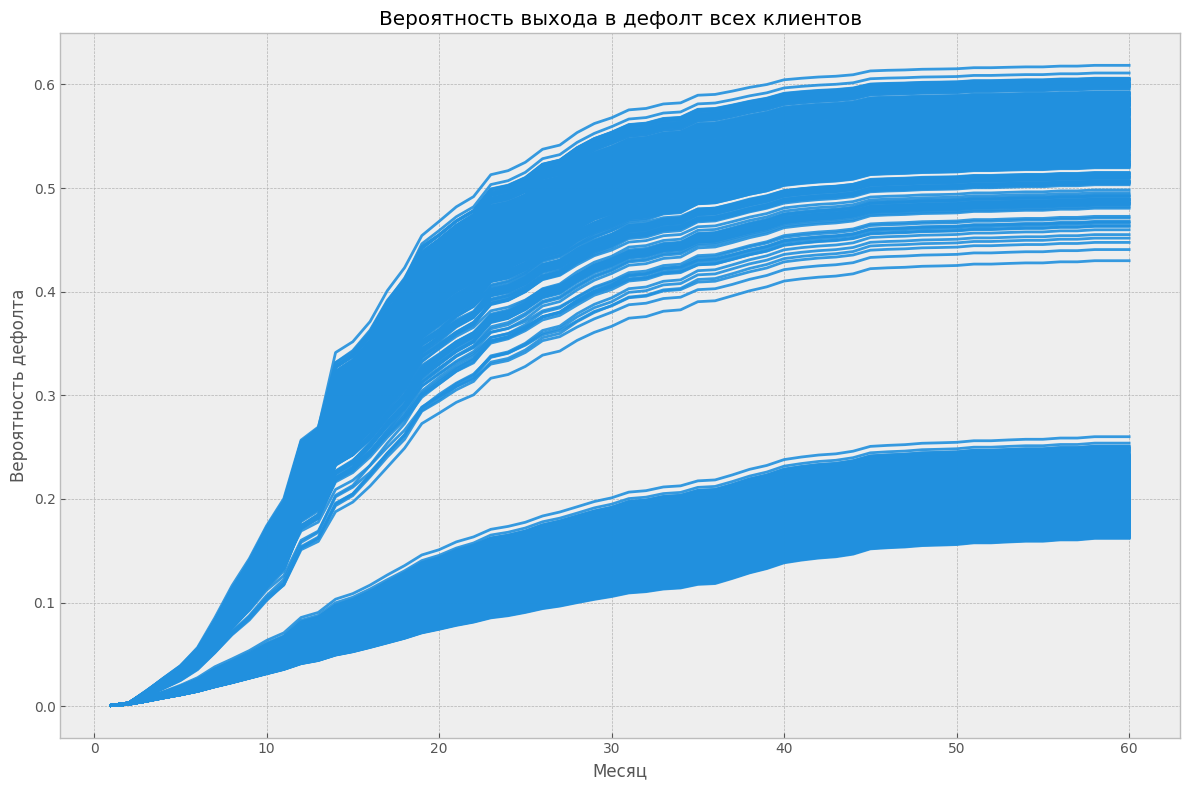

In [45]:
print('Для полученных данных построим кривые вероятности выхода в дефолт для всех клиентов:\n')
plot_all_cis(rev_mean)

In [46]:
print('Видно, что данных много, поэтому несмотря на прозрачность цвета, линии активно наслаиваются друг на друга')
print('По насыщенности цвета в разных частях графика можно судить о динамике выхода в дефолт для данных датасета')
print('Так, нетрудно заметить, что некоторая часть клиентов имеют высокую вероятность выхода в дефолт уже после 20-30 месяца')
print('Это та меньшая часть клиентов, которые все же просрочили свой кредит и вышли в дефолт')
print('Большая же часть клиентов сосредоточена в нижней части графика и имеет довольно низкую вероятность выхода в дефолт (порядка 20%) на протяжении всех 60 месяцев')
print('Это говорит о том, что большая часть клиентов, все таки выплатила свой кредит, из-за чего кривых с малой вероятностью дефолта очень много и сосредоточены они очень кучно')
print('Исходя из предварительного обзора можно будет предположить, что итоговая средняя кривая выживаемости будет плавно спускаться до определенного значения, а далее быть около константной')
print('Скорее всего, вероятность дефолта не опустится ниже 70-80%, причем вероятность выживания будет падать до 30-40 месяца, а затем фиксироваться на определенном значении')
print('Эти предварительные гипотезы проверятся далее при моделировании на большем объеме данных')

Видно, что данных много, поэтому несмотря на прозрачность цвета, линии активно наслаиваются друг на друга
По насыщенности цвета в разных частях графика можно судить о динамике выхода в дефолт для данных датасета
Так, нетрудно заметить, что некоторая часть клиентов имеют высокую вероятность выхода в дефолт уже после 20-30 месяца
Это та меньшая часть клиентов, которые все же просрочили свой кредит и вышли в дефолт
Большая же часть клиентов сосредоточена в нижней части графика и имеет довольно низкую вероятность выхода в дефолт (порядка 20%) на протяжении всех 60 месяцев
Это говорит о том, что большая часть клиентов, все таки выплатила свой кредит, из-за чего кривых с малой вероятностью дефолта очень много и сосредоточены они очень кучно
Исходя из предварительного обзора можно будет предположить, что итоговая средняя кривая выживаемости будет плавно спускаться до определенного значения, а далее быть около константной
Скорее всего, вероятность дефолта не опустится ниже 70-80%, причем вероя

In [47]:
print('Для наглядности также посмотрим чуть внимательнее на кривую выживаемости клиентов с наибольшей и наименьшей вероятностью выхода в дефолт на 60 месяц')
print('Кредит с наибольшей вероятностью выхода в дфеолт на 60 месяц:')
min_row = mean[mean[60] == mean[60].min()][:1]
min_ind = min_row.index.values.astype(int)[0]
display(min_row)
print('\nИнформация об этом кредите:')
display(data[data.index == min_ind])

print('\n\n-----======-----\n\n')

print('Кредит с наименьшей вероятностью выхода в дфеолт на 60 месяц:')
max_row = mean[mean[60] == mean[60].max()][:1]
max_ind = max_row.index.values.astype(int)[0]
display(max_row)
print('\nИнформация об этом кредите:')
display(data[data.index == max_ind])

Для наглядности также посмотрим чуть внимательнее на кривую выживаемости клиентов с наибольшей и наименьшей вероятностью выхода в дефолт на 60 месяц
Кредит с наибольшей вероятностью выхода в дфеолт на 60 месяц:


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
722,0.999,0.997,0.987,0.975,0.963,0.945,0.920,0.887,0.861,0.827,0.802,0.745,0.731,0.659,0.648,0.629,0.599,0.577,0.546,0.532,0.518,0.508,0.487,0.483,0.475,0.463,0.459,0.447,0.438,0.432,0.425,0.423,0.419,0.418,0.410,0.410,0.406,0.403,0.400,0.396,0.394,0.393,0.392,0.391,0.387,0.386,0.386,0.385,0.385,0.385,0.384,0.384,0.383,0.383,0.383,0.382,0.382,0.382,0.382,0.382



Информация об этом кредите:


,loan_amnt,grade,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_util,initial_list_status,recoveries,application_type,tot_coll_amt,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,mo_sin_old_il_acct,mort_acc,num_il_tl,num_rev_tl_bal_gt_0,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,disbursement_method,debt_settlement_flag,loan_result,lines_acc_diff,num_rev_acc_diff,mo_tl_op_diff,mths_since_recent_diff,num_sats_diff,fico_range_avg,duration,home_ownership_OWN,home_ownership_RENT,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_other,addr_state_NorthEast,addr_state_SouthEast,addr_state_SouthWest,addr_state_West
722,14000.000,5,44500.000,1,20.050,0.000,0.000,0.000,82.300,1,577.470,1,0.000,14800.000,1.000,2090.000,39.000,0.000,1.000,8.000,0.000,100.000,83.300,0.000,38593.000,25075.000,7600.000,1,1,1,1.000,1.000,49.000,-14.000,6.000,672.000,27.000,0,1,1,0,0,0,0,1,0,0




-----======-----


Кредит с наименьшей вероятностью выхода в дфеолт на 60 месяц:


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
433,0.999,0.998,0.995,0.992,0.989,0.986,0.981,0.977,0.973,0.969,0.965,0.959,0.956,0.951,0.947,0.943,0.939,0.934,0.929,0.926,0.922,0.919,0.915,0.913,0.909,0.906,0.903,0.900,0.897,0.894,0.891,0.889,0.887,0.886,0.882,0.882,0.877,0.871,0.867,0.862,0.859,0.857,0.856,0.853,0.848,0.847,0.846,0.845,0.845,0.844,0.842,0.842,0.841,0.841,0.841,0.840,0.840,0.838,0.838,0.838



Информация об этом кредите:


,loan_amnt,grade,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_util,initial_list_status,recoveries,application_type,tot_coll_amt,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,mo_sin_old_il_acct,mort_acc,num_il_tl,num_rev_tl_bal_gt_0,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,disbursement_method,debt_settlement_flag,loan_result,lines_acc_diff,num_rev_acc_diff,mo_tl_op_diff,mths_since_recent_diff,num_sats_diff,fico_range_avg,duration,home_ownership_OWN,home_ownership_RENT,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_other,addr_state_NorthEast,addr_state_SouthEast,addr_state_SouthWest,addr_state_West
433,22400.000,5,96000.000,1,20.450,1.000,0.000,0.000,85.100,1,0.000,1,0.000,12700.000,5.000,7006.000,137.000,3.000,12.000,3.000,0.000,88.900,100.000,0.000,90463.000,70059.000,12700.000,1,1,0,9.000,0.000,101.000,5.000,7.000,677.000,60.000,0,1,1,0,0,0,0,0,1,0


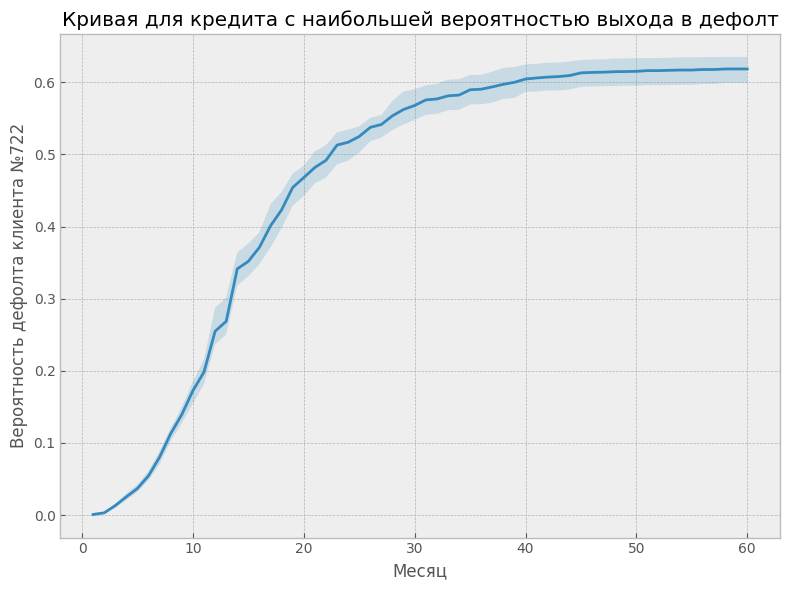

In [48]:
plot_ci(rev_mean, rev_upper_ci, rev_lower_ci, i = min_ind, title = 'Кривая для кредита с наибольшей вероятностью выхода в дефолт', figsize = (8, 6))

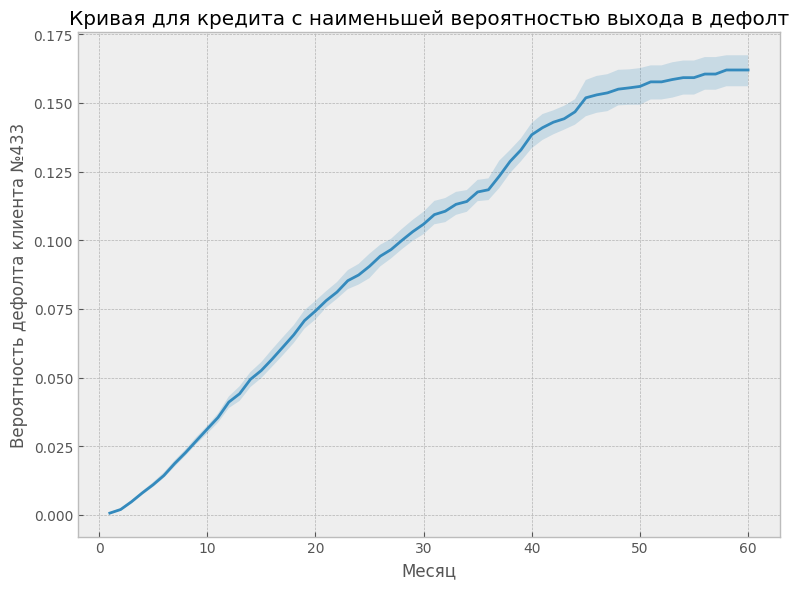

In [49]:
plot_ci(rev_mean, rev_upper_ci, rev_lower_ci, i = max_ind, title = 'Кривая для кредита с наименьшей вероятностью выхода в дефолт', figsize = (8, 6))

In [ ]:
print('Две этих кривых показывают два крайних случая - один из клиентов имеет наибольшую вероятность выхода в дефолт к концу 60 месяца, другой наименьшую')
print('Видно, что для первого клиента шанс выхода в дефолт к 20 месяцу уже равен 50%, а к 30 месяцу - 60%. Далее вероятность дефолта остается около константной')
print('Кривая второго клиента равномерно возрастает на протяжении всего времени, а к 60 месяцу вероятность выхода в дефолт для него составляет всего 15%')

Две этих кривых показывают два крайних случая - один из клиентов имеет наибольшую вероятность выхода в дефолт к концу 60 месяца, другой наименьшую
Видно, что для первого клиента шанс выхода в дефолт к 20 месяцу уже равен 50%, а к 30 месяцу - 60%. Далее вероятность дефолта остается около константной
Кривая второго клиента равномерно возрастает на протяжении всего времени, а к 60 месяцу вероятность выхода в дефолт для него составляет всего 15%


### Моделирование на большем объеме данных - 500_000 строк

#### Выборка данных для поиска гиперпараметров

In [50]:
print('Так как исходная выборка слишком большая и мощности Google Collab сильно ограничены по ОЗУ и другим ресурсам, для моделирования возьмем часть данных')
print('Из исходного датасета возьмем случайным образом 500.000 строк и будем обучать модель уже на них')
print('Самой точной моделью для задачи кредитного скоринга является XGBSEDebiasedBCE, будем использовать ее.')
df = data.sample(n = 500_000)
print(f'Размер датасета для моделирования: {df.shape}')
df.head()

Так как исходная выборка слишком большая и мощности Google Collab сильно ограничены по ОЗУ и другим ресурсам, для моделирования возьмем часть данных
Из исходного датасета возьмем случайным образом 500.000 строк и будем обучать модель уже на них
Самой точной моделью для задачи кредитного скоринга является XGBSEDebiasedBCE, будем использовать ее.
Размер датасета для моделирования: (500000, 47)


,loan_amnt,grade,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_util,initial_list_status,recoveries,application_type,tot_coll_amt,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,mo_sin_old_il_acct,mort_acc,num_il_tl,num_rev_tl_bal_gt_0,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,disbursement_method,debt_settlement_flag,loan_result,lines_acc_diff,num_rev_acc_diff,mo_tl_op_diff,mths_since_recent_diff,num_sats_diff,fico_range_avg,duration,home_ownership_OWN,home_ownership_RENT,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_other,addr_state_NorthEast,addr_state_SouthEast,addr_state_SouthWest,addr_state_West
468031,16100.000,5,35000.000,1,26.890,0.000,0.000,0.000,64.000,1,790.000,1,81.000,30200.000,1.000,1757.000,125.797,0.000,0.000,11.000,0.000,84.200,75.000,0.000,30200.000,19332.000,17300.000,1,0,1,8.000,8.000,281.000,15.559,7.000,682.000,11.000,0,1,1,0,0,0,0,0,0,1
625104,15000.000,6,116600.000,0,8.430,2.000,1.000,0.000,88.000,0,0.000,1,0.000,26900.000,2.000,3380.000,111.000,3.000,3.000,4.000,2.000,84.200,60.000,0.000,26900.000,23661.000,25100.000,1,1,0,13.000,7.000,125.000,-3.000,2.000,667.000,36.000,0,1,1,0,0,0,0,1,0,0
977205,8575.000,4,40000.000,2,20.160,1.000,1.000,1.000,81.200,0,676.700,1,0.000,4500.000,3.000,806.000,56.000,0.000,1.000,7.000,0.000,100.000,100.000,1.000,21532.000,6445.000,3600.000,1,1,1,4.000,4.000,199.000,7.000,3.000,667.000,20.000,0,1,0,0,0,0,0,0,1,0
675633,14000.000,4,60000.000,0,11.540,0.000,0.000,0.000,73.200,0,0.000,1,0.000,21400.000,4.000,1424.000,125.797,0.000,0.000,8.000,0.000,100.000,66.700,0.000,21400.000,15665.000,8000.000,1,1,0,8.000,8.000,178.000,15.559,8.000,687.000,36.000,0,1,0,0,0,0,0,0,0,1
654344,6000.000,5,45000.000,2,34.670,1.000,0.000,0.000,49.400,0,0.000,1,0.000,13000.000,8.000,6091.000,120.000,1.000,11.000,7.000,1.000,96.700,50.000,0.000,78489.000,67002.000,3500.000,1,1,0,18.000,8.000,104.000,12.000,10.000,672.000,36.000,0,1,0,0,0,0,0,1,0,0


Посмотрим на распределение таргетных переменных для моделирования - duration и loan_result:



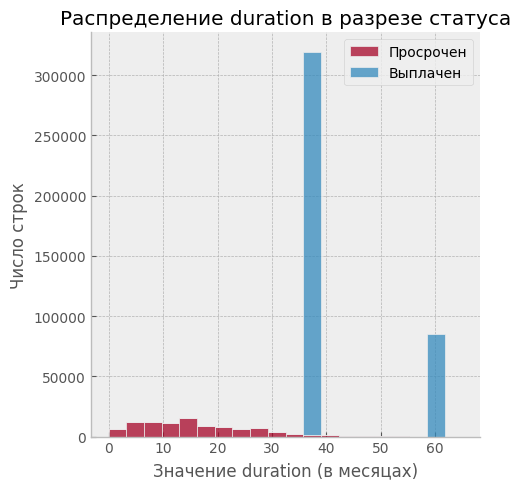

In [51]:
print('Посмотрим на распределение таргетных переменных для моделирования - duration и loan_result:\n')
plot_dis(df)

Распределение данных схоже с распределением данных полного датасета:



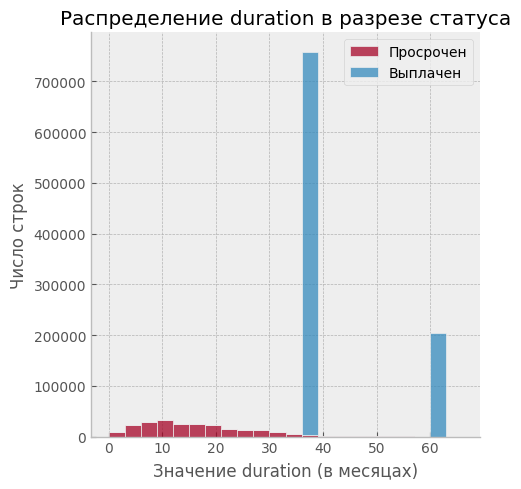

In [52]:
print('Распределение данных схоже с распределением данных полного датасета:\n')
plot_dis(data)

In [14]:
print('Перейдем к поиску оптимальных гиперпараметров с помощью собственного способа поиска по сетке')
print('Для этого выбранные случайным образом 500.000 строк и будем использовать для поиска оптимальных гиперпараметров модели')
print('400.000 строк используем для фита, оставшиеся 100.000 для оценки модели с конкретными параметрами и ранней остановки, чтобы избежать оверфитинга')
print('То есть, 400.000 и 100.000 строк обозначим как данные для фита и данные для оценки и будем делать следующее:')
print('Для каждого набора параметров будем фитить модель на 400.000 строк, используя в качестве параметра для остановки и средства против оверфитинга 100.000 строк для оценки')
print('Затем будем использовать эти 100.000 строк для скоринг-оценки модели - в нашем случае это будет C-index')
print('Итого, после перебора всех параметров будут найдены оптимальные по показателю C-index параметры, которые будут использованы для построения итоговой средней кривой')
print('Для получения результирующей модели обучим модель с лучшими гиперпараметрами на соответствующих 500.000 строк и получим итоговую модель, которую можно сохранить в пикл')
print('Для оценки качества модели и построения средней кривой выживаемости используем 100.000 случайных строк датасета, которые мы не использовали на предыдущем этапе')
print('Именно эти данные будут валидационными данными нашей модели - на них мы посчитаем результирующий C-index и сравним среднюю кривую с кривой Каплана-Мейера для оценки модели')

X = df.drop(['duration', 'loan_result'], axis = 1)
y = convert_to_structured(df['duration'], df['loan_result'])

(X_fit, X_score, y_fit, y_score) = train_test_split(X, y, test_size = 0.2, random_state = 42)

Перейдем к поиску оптимальных гиперпараметров с помощью собственного способа поиска по сетке
Для этого выбранные случайным образом 500.000 строк и будем использовать для поиска оптимальных гиперпараметров модели
400.000 строк используем для фита, оставшиеся 100.000 для оценки модели с конкретными параметрами и ранней остановки, чтобы избежать оверфитинга
То есть, 400.000 и 100.000 строк обозначим как данные для фита и данные для оценки и будем делать следующее:
Для каждого набора параметров будем фитить модель на 400.000 строк, используя в качестве параметра для остановки и средства против оверфитинга 100.000 строк для оценки
Затем будем использовать эти 100.000 строк для скоринг-оценки модели - в нашем случае это будет C-index
Итого, после перебора всех параметров будут найдены оптимальные по показателю C-index параметры, которые будут использованы для построения итоговой средней кривой
Для получения результирующей модели обучим модель с лучшими гиперпараметрами на соответствующих 500

#### Поиск лучших гиперпараметров

In [ ]:
MIN_PARAMS = {
    "objective": "survival:aft",
    "eval_metric": "aft-nloglik",
    "aft_loss_distribution": "normal",
    "aft_loss_distribution_scale": 1,
    "tree_method": "hist",
    "booster": "gbtree",
    "min_child_weight": 50, 
    "colsample_bynode": 0.5, 
    "max_depth": 3,        # Grid Search [3, 6, 8]
    "learning_rate": 0.2,  # Grid Search [0.1, 0.2]
    "subsample": 0.5,      # Grid Search [0.5, 0.8]
}

N_ESTIMATORS = 10          # Grid Search [10, 20]

EARLY_STOPPING_ROUNDS = 10

PARAMS_LR = {
    'C': 1e-3,
    'max_iter': 500
}

In [ ]:
max_depths = [3, 6, 8]
learning_rates = [0.1, 0.2]
subsamples = [0.5, 0.8]
n_estimators = [10, 20]

print('Перейдем к поиску оптимальных гиперпараметров модели')
print('Перебирать гиперпатаметры для XGBoost будем в следующих диапазонах:')
print(f'Параметр max_depth: {max_depths}')
print(f'Параметр learning_rate: {learning_rates}')
print(f'Параметр subsample: {subsamples}')
print(f'Параметр n_estimator: {n_estimators}')
print(f'Всего комбинаций гиперпараметров будет: {len(max_depths) * len(learning_rates) * len(subsamples) * len(n_estimators)}')

print('\nОстальные стандартные гиперпараметры оставим без изменения, а именно:')
BASE_PARAMS = MIN_PARAMS
del BASE_PARAMS['max_depth']
del BASE_PARAMS['learning_rate']
del BASE_PARAMS['subsample']
display(BASE_PARAMS)

Перейдем к поиску оптимальных гиперпараметров модели
Перебирать гиперпатаметры для XGBoost будем в следующих диапазонах:
Параметр max_depth: [3, 6, 8]
Параметр learning_rate: [0.1, 0.2]
Параметр subsample: [0.5, 0.8]
Параметр n_estimator: [10, 20]
Всего комбинаций гиперпараметров будет: 24

Остальные стандартные гиперпараметры оставим без изменения, а именно:


{'objective': 'survival:aft',
 'eval_metric': 'aft-nloglik',
 'aft_loss_distribution': 'normal',
 'aft_loss_distribution_scale': 1,
 'tree_method': 'hist',
 'booster': 'gbtree',
 'min_child_weight': 50,
 'colsample_bynode': 0.5}

In [ ]:
print('Запустим поиск гиперпараметров, на каждой итерации замеряя время работы и показатель C-index у модели')

Запустим поиск гиперпараметров, на каждой итерации замеряя время работы и показатель C-index у модели


In [ ]:
import time

def fit_params(md, lr, ss, ne):
  PARAMS = MIN_PARAMS
  PARAMS['max_depth'] = md
  PARAMS['learning_rate'] = lr
  PARAMS['subsample'] = ss
  PARAMS['n_estimators'] = ne

  start_time = time.time()
  base_model = XGBSEDebiasedBCE(PARAMS, PARAMS_LR)
  bootstrap_estimator = XGBSEBootstrapEstimator(base_model, n_estimators = ne)

  bootstrap_estimator.fit(
      X_fit,
      y_fit,
      validation_data = (X_score, y_score),
      early_stopping_rounds = EARLY_STOPPING_ROUNDS,
      time_bins = TIME_BINS,
  )
  
  mean = bootstrap_estimator.predict(X_score, return_ci = False)
  cind = concordance_index(y_score, mean) * 100
    
  elapsed_secs = time.time() - start_time
  print(f'{iter})')
  print(f'Параметры: max_depths: {md}, learning_rate: {lr}, subsample: {ss}, n_estimators: {ne}')
  print(f'Скоринговое значение C-index: {cind:.3f}')
  print(f'Время: {elapsed_secs // 60} min, {elapsed_secs % 60:.0f} sec\n')

  del base_model
  del bootstrap_estimator
  del mean

  return (cind, PARAMS)

In [ ]:
cind_params_dict = []
counter = 0

for md in max_depths:
  for lr in learning_rates:
    for ss in subsamples:
      for ne in n_estimators:
        print(f'{counter})')
        cind, params = fit_params(md, lr, ss, ne)
        cind_params_dict.append((cind, params))
        counter += 1 

0)
<built-in function iter>)
Параметры: max_depths: 3, learning_rate: 0.1, subsample: 0.5, n_estimators: 10
Скоринговое значение C-index: 88.033
Время: 67.0 min, 29 sec

1)
<built-in function iter>)
Параметры: max_depths: 3, learning_rate: 0.1, subsample: 0.5, n_estimators: 20
Скоринговое значение C-index: 88.044
Время: 126.0 min, 59 sec

2)
<built-in function iter>)
Параметры: max_depths: 3, learning_rate: 0.1, subsample: 0.8, n_estimators: 10
Скоринговое значение C-index: 88.062
Время: 75.0 min, 28 sec

3)
<built-in function iter>)
Параметры: max_depths: 3, learning_rate: 0.1, subsample: 0.8, n_estimators: 20
Скоринговое значение C-index: 88.102
Время: 177.0 min, 22 sec

4)
<built-in function iter>)
Параметры: max_depths: 3, learning_rate: 0.2, subsample: 0.5, n_estimators: 10
Скоринговое значение C-index: 87.812
Время: 21.0 min, 25 sec

5)
<built-in function iter>)
Параметры: max_depths: 3, learning_rate: 0.2, subsample: 0.5, n_estimators: 20
Скоринговое значение C-index: 87.828
Вре

#### Определение лучших гиперпараметров

In [15]:
best_cind = 0
best_params = ()
for tup in cind_params_dict:
    if tup[0] >= best_cind:
        best_cind = tup[0]
        best_params = tup[1]
        
print(f'Лучший результат модели: {best_cind:.3f}')
print('Лчушие параметры:')
display(best_params)

Лучший результат модели: 88.102
Лчушие параметры:


{'objective': 'survival:aft',
 'eval_metric': 'aft-nloglik',
 'aft_loss_distribution': 'normal',
 'aft_loss_distribution_scale': 1,
 'tree_method': 'hist',
 'booster': 'gbtree',
 'min_child_weight': 50,
 'colsample_bynode': 0.5,
 'max_depth': 3,
 'learning_rate': 0.1,
 'subsample': 0.8,
 'n_estimators': 20}

In [16]:
print('В результате долгого перебора гиперпараметров, получили наилучшие параметры для модели:')
print(f'''max_depths: {best_params['max_depth']}, learning_rate: {best_params['learning_rate']}, subsample: {best_params['subsample']}, n_estimators: {best_params['n_estimators']}''')
print(f'Скоринговое значение C-index: {best_cind}')

В результате долгого перебора гиперпараметров, получили наилучшие параметры для модели:
max_depths: 3, learning_rate: 0.1, subsample: 0.8, n_estimators: 20
Скоринговое значение C-index: 88.102


### Построение и сохранение результирующей модели

In [17]:
print('Используем найденнные лучшие параметры для построения итоговой модели, которую потом засунем в пикл')

PARAMS = best_params
N_ESTIMATORS = best_params['n_estimators']

del PARAMS['n_estimators']

Используем найденнные лучшие параметры для построения итоговой модели, которую потом засунем в пикл


In [ ]:
print('Обучим результирующую модель с лучшими параметрами')
start_time = time.time()
best_model = XGBSEDebiasedBCE(PARAMS, PARAMS_LR)
best_estimator = XGBSEBootstrapEstimator(best_model, n_estimators = N_ESTIMATORS)

best_estimator.fit(
    X_fit,
    y_fit,
    validation_data = (X_score, y_score),
    early_stopping_rounds = EARLY_STOPPING_ROUNDS,
    time_bins = TIME_BINS,
)

elapsed_secs = time.time() - start_time
print('Результирующая модель')
print(f'Время: {elapsed_secs // 60} min, {elapsed_secs % 60:.0f} sec\n')

Обучим результирующую модель с лучшими параметрами
Результирующая модель
Время: 175.0 min, 34 sec


In [ ]:
import pickle

print('Сохраним модель в пикл estimator.pkl, чтобы впоследствии переиспользовать ее')
with open("estimator.pkl", "wb") as f:
    pickle.dump(best_estimator, f)

Сохраним модель в пикл estimator.pkl, чтобы впоследствии переиспользовать ее


### Оценка результирующей модели

In [13]:
import pickle

with open('drive/MyDrive/Course Work/estimator.pkl', 'rb') as f:
  best_estimator = pickle.load(f)

In [54]:
df_valid = data[data.index.isin(df.index) == False].sample(n = 100_000)

print('Для оценки модели используем те данные, которые не были использованы на предыдущем этапе:')
print(f'Размер оценочной выборки: {df_valid.shape}\n')
df_valid.head()

Для оценки модели используем те данные, которые не были использованы на предыдущем этапе:
Размер оценочной выборки: (100000, 47)



,loan_amnt,grade,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_util,initial_list_status,recoveries,application_type,tot_coll_amt,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,mo_sin_old_il_acct,mort_acc,num_il_tl,num_rev_tl_bal_gt_0,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,disbursement_method,debt_settlement_flag,loan_result,lines_acc_diff,num_rev_acc_diff,mo_tl_op_diff,mths_since_recent_diff,num_sats_diff,fico_range_avg,duration,home_ownership_OWN,home_ownership_RENT,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_other,addr_state_NorthEast,addr_state_SouthEast,addr_state_SouthWest,addr_state_West
33467,19750.000,6,78000.000,0,33.660,0.000,0.000,0.000,77.100,1,0.000,1,0.000,40100.000,7.000,11337.000,242.000,1.000,28.000,11.000,0.000,93.700,100.000,0.000,293268.000,115726.000,21000.000,1,1,0,23.000,6.000,239.000,39.000,20.000,687.000,36.000,0,0,0,0,0,0,0,0,1,0
590479,12000.000,6,82000.000,2,32.780,1.000,0.000,0.000,54.300,1,0.000,1,0.000,31100.000,3.000,18363.000,110.000,1.000,12.000,8.000,0.000,96.700,20.000,0.000,410953.000,62235.000,16300.000,1,1,0,16.000,9.000,143.000,15.559,9.000,702.000,36.000,0,0,1,0,0,0,0,0,0,1
785504,18000.000,7,100000.000,1,19.390,0.000,0.000,0.000,60.100,1,0.000,1,0.000,51000.000,5.000,32267.000,113.000,4.000,9.000,3.000,0.000,100.000,33.300,0.000,291352.000,67828.000,51000.000,1,1,0,8.000,0.000,138.000,34.000,5.000,717.000,36.000,0,0,1,0,0,0,0,0,1,0
907883,20000.000,7,102000.000,1,15.510,0.000,1.000,0.000,46.900,1,0.000,1,0.000,62500.000,1.000,17478.000,151.000,4.000,3.000,12.000,0.000,100.000,0.000,0.000,353573.000,44337.000,51300.000,1,1,0,7.000,2.000,127.000,11.000,5.000,737.000,36.000,0,0,1,0,0,0,0,0,0,1
189735,15000.000,7,125000.000,0,10.290,0.000,1.000,0.000,58.700,0,0.000,1,0.000,50500.000,4.000,16214.000,106.000,6.000,3.000,9.000,0.000,100.000,44.400,0.000,353943.000,32838.000,23500.000,1,1,0,11.000,3.000,162.000,8.000,10.000,707.000,36.000,0,0,1,0,0,0,0,0,0,0


In [55]:
X_valid = df_valid.drop(['duration', 'loan_result'], axis = 1)
y_valid = convert_to_structured(df_valid['duration'], df_valid['loan_result'])

mean, upper_ci, lower_ci = best_estimator.predict(X_valid, return_ci = True)
cind = concordance_index(y_valid, mean) * 100
print(f'Оценка результирующей модели (C-index): {cind:.3}%')  

Оценка результирующей модели (C-index): 88.1%


In [16]:
print('Вероятности выживания, предсказанные результирующей моделью:')
mean.head()

Вероятности выживания, предсказанные результирующей моделью:


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.999,0.998,0.994,0.990,0.985,0.981,0.976,0.971,0.966,0.961,0.958,0.952,0.949,0.944,0.941,0.938,0.934,0.930,0.926,0.924,0.921,0.918,0.915,0.913,0.911,0.908,0.907,0.904,0.902,0.900,0.898,0.897,0.894,0.894,0.892,0.891,0.885,0.882,0.878,0.876,0.874,0.871,0.870,0.868,0.866,0.865,0.864,0.863,0.862,0.861,0.860,0.859,0.858,0.858,0.857,0.857,0.857,0.856,0.856,0.856
1,1.000,0.999,0.999,0.998,0.997,0.996,0.995,0.993,0.992,0.990,0.989,0.987,0.986,0.984,0.984,0.982,0.981,0.980,0.978,0.977,0.975,0.974,0.973,0.972,0.971,0.970,0.969,0.968,0.968,0.966,0.966,0.965,0.964,0.963,0.962,0.962,0.956,0.953,0.950,0.948,0.947,0.944,0.943,0.941,0.939,0.937,0.936,0.936,0.935,0.934,0.933,0.932,0.931,0.931,0.931,0.930,0.930,0.930,0.930,0.930
2,1.000,1.000,0.999,0.998,0.997,0.997,0.995,0.994,0.992,0.991,0.990,0.988,0.987,0.985,0.984,0.982,0.981,0.979,0.978,0.977,0.975,0.973,0.972,0.970,0.969,0.968,0.967,0.966,0.965,0.964,0.963,0.962,0.961,0.960,0.959,0.959,0.951,0.948,0.943,0.940,0.937,0.935,0.933,0.931,0.929,0.927,0.926,0.926,0.924,0.923,0.922,0.921,0.921,0.920,0.920,0.919,0.919,0.919,0.919,0.919
3,0.999,0.996,0.991,0.986,0.980,0.970,0.962,0.955,0.949,0.939,0.934,0.922,0.917,0.906,0.902,0.896,0.889,0.883,0.875,0.872,0.866,0.862,0.855,0.851,0.846,0.840,0.837,0.833,0.829,0.825,0.821,0.819,0.816,0.814,0.811,0.810,0.796,0.790,0.783,0.779,0.776,0.772,0.769,0.766,0.763,0.762,0.760,0.759,0.757,0.756,0.755,0.753,0.752,0.751,0.751,0.751,0.750,0.750,0.750,0.750
4,1.000,0.999,0.998,0.997,0.995,0.994,0.992,0.991,0.990,0.988,0.987,0.985,0.984,0.983,0.982,0.981,0.979,0.978,0.977,0.976,0.975,0.974,0.973,0.972,0.972,0.971,0.970,0.969,0.968,0.968,0.967,0.966,0.965,0.965,0.964,0.964,0.958,0.956,0.953,0.951,0.949,0.947,0.946,0.944,0.943,0.941,0.941,0.940,0.939,0.938,0.937,0.937,0.936,0.936,0.935,0.935,0.935,0.934,0.934,0.934


Проверим, как построилась кривая выживания, например, для третьего клиента:



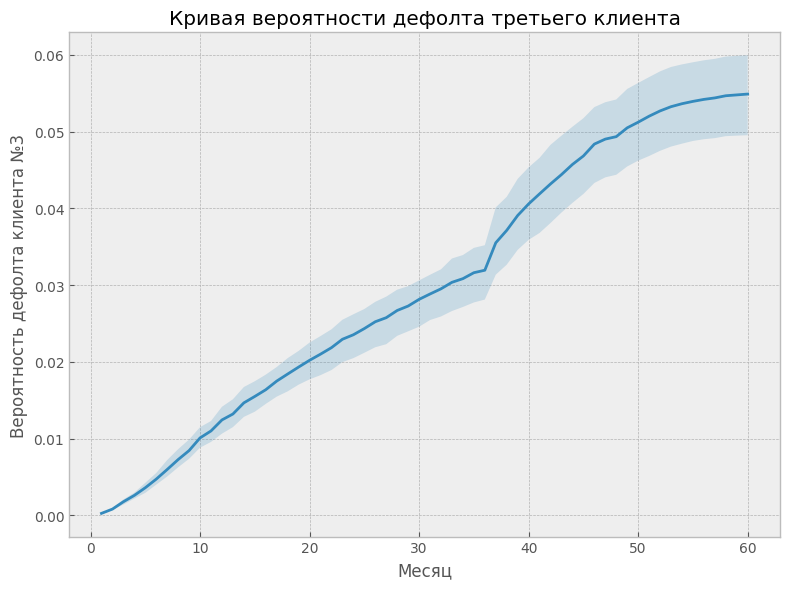

In [56]:
rev_mean = 1 - mean
rev_upper_ci = 1 - upper_ci
rev_lower_ci = 1 - lower_ci

print('Проверим, как построилась кривая выживания, например, для третьего клиента:\n')
plot_ci(rev_mean, rev_upper_ci, rev_lower_ci, i = 3, title = 'Кривая вероятности дефолта третьего клиента', figsize = (8, 6))

In [18]:
print('Для некоторых кредитов поле duration оказалось равно 61, исключим такие строки, чтобы обозревать кривые только на 60 месяцев')
df_valid = df_valid[df_valid.duration < 61]

Для некоторых кредитов поле duration оказалось равно 61, исключим такие строки, чтобы обозревать кривые только на 60 месяцев


Сравним с актуальной кривой Каплана-Мейерa



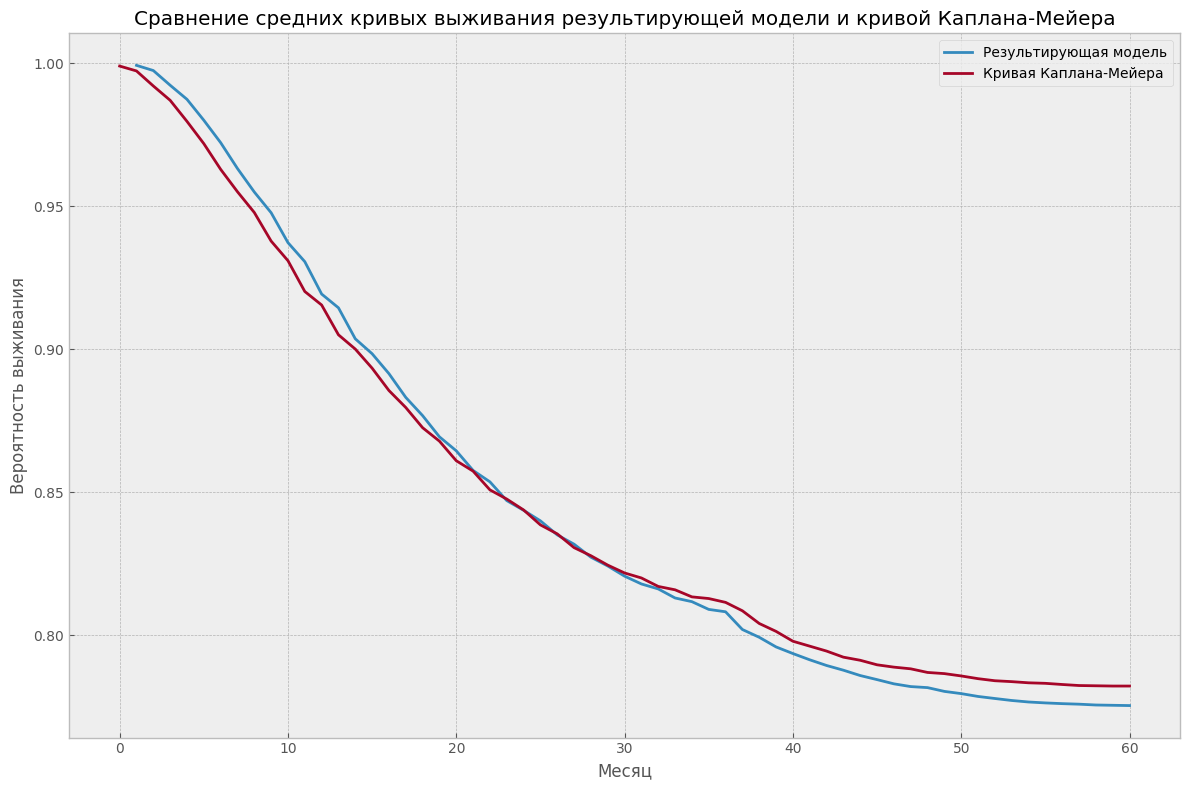

In [23]:
from lifelines import KaplanMeierFitter

print('Сравним с актуальной кривой Каплана-Мейерa\n')

kmf = KaplanMeierFitter()
kmf.fit(df_valid['duration'], event_observed = df_valid['loan_result'])

plt.figure(figsize = (12, 8))
plt.plot(mean.mean())
plt.plot(kmf.survival_function_)
plt.legend(['Результирующая модель', 'Кривая Каплана-Мейера'])

plt.title('Сравнение средних кривых выживания результирующей модели и кривой Каплана-Мейера')
plt.xlabel('Месяц')
plt.ylabel(f'Вероятность выживания')
plt.tight_layout()

In [ ]:
print('Как видно из графика, средняя кривая, предсказанная натренированной моделью и кривая Каплана-Мейера очень схожи')
print('Скоринговое значение C-index также довольно высокое - порядка 88%')
print('Эти факторы говорят о хорошем качестве полученной модели')
print('Поставленные задачи выполнены, модель может быть успешно интегрирована в production-среду и использоваться для будущих наработок')

Как видно из графика, средняя кривая, предсказанная натренированной моделью и кривая Каплана-Мейера очень схожи
Скоринговое значение C-index также довольно высокое - порядка 88%
Эти факторы говорят о хорошем качестве полученной модели
Поставленные задачи выполнены, модель может быть успешно интегрирована в production-среду и использоваться для будущих наработок
